In [105]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob

%matplotlib notebook
%matplotlib notebook

In [106]:
files = glob.glob('/Users/sriharsha/Documents/Cookie_challenge/Data/raw_photos/*.jpg')
print(len(files))

18


In [3]:
def segment_object(img):

    #Preprocessing of image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(5,5),3)

    #Otsu thresholding for dynamic boundary creation 
    ret,th = cv2.threshold(blur,0,255,cv2.THRESH_OTSU)
    
    
    #Morphological operations to remove speckle noise after threshold
    kernel = np.ones((5,5),np.uint8)
    new_edges = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel)

    _,contour, hierarchy = cv2.findContours(new_edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    final_contours = []

    for e, cnt in enumerate(contour):

        area = cv2.contourArea(contour[e])
        x,y,w,h = cv2.boundingRect(contour[e])
        rect_area = w*h
        extent = float(area)/rect_area

        if cv2.contourArea(contour[e])> 5000 and extent > 0.50 and (area/(img.shape[0] * img.shape[1]))< 0.7 and min(w,h)/max(w,h) > 0.5:
            final_contours.append(contour[e])
        
    final_contours = np.asarray(final_contours)

    return final_contours

In [173]:
idx = 13
img = cv2.imread(files[idx])
im_crops = []
final_contours = segment_object(img.copy())
for e, cnt in enumerate(final_contours):
    x, y, w, h = cv2.boundingRect(cnt)
    roi = img[y:y+h, x:x+w]
    im_crops.append(roi)

<IPython.core.display.Javascript object>


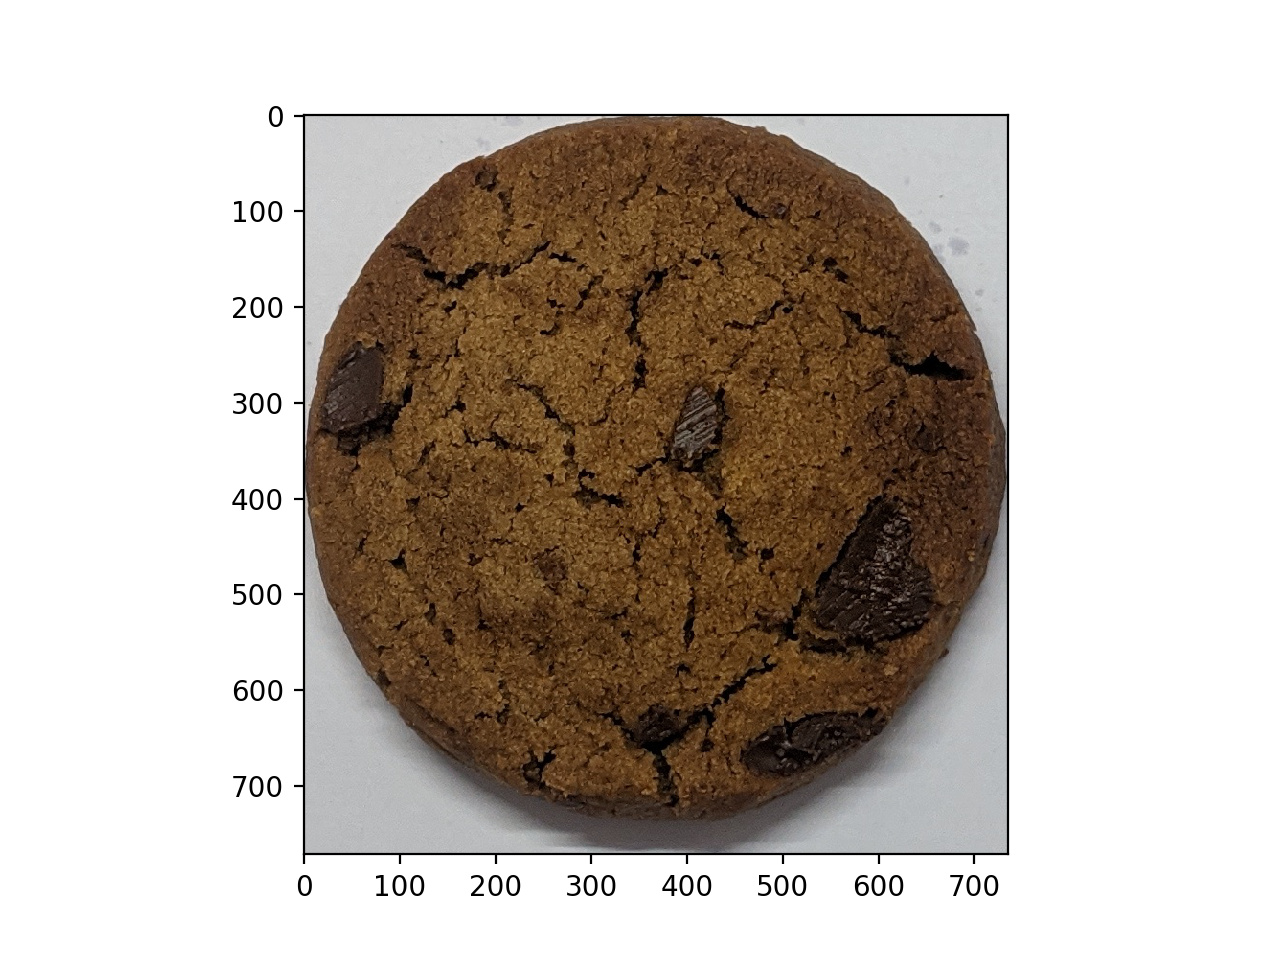

In [174]:
plt.imshow(im_crops[0][:,:,::-1])

In [7]:
img_c = im_crops[0][:,:,::-1]


/Users/sriharsha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


<IPython.core.display.Javascript object>


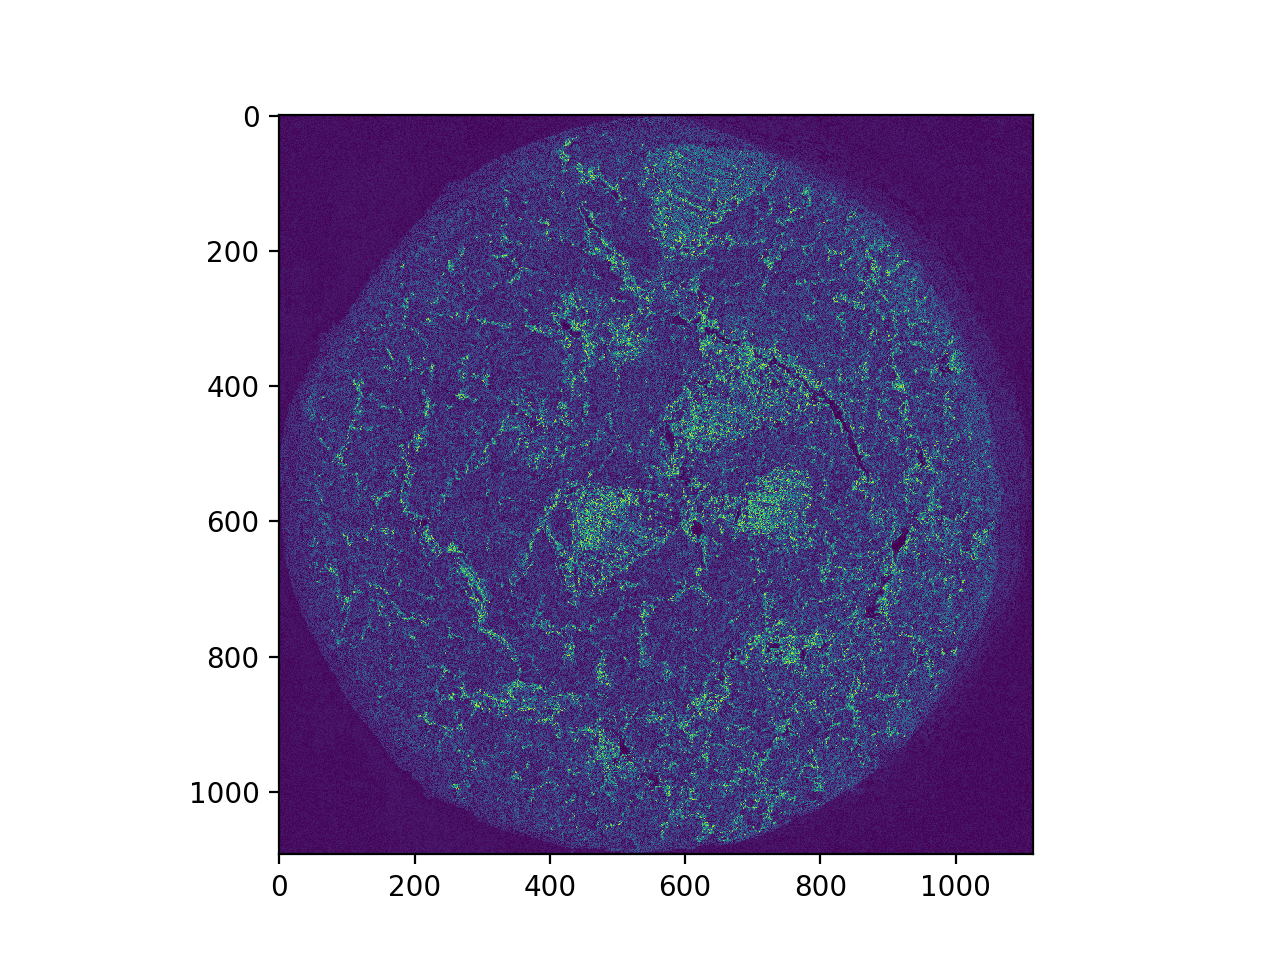

In [104]:
from skimage import exposure
gray = cv2.cvtColor(img_c, cv2.COLOR_BGR2GRAY)
# gray = cv2.medianBlur(gray, 11)
xyz = cv2.cvtColor(img_c, cv2.COLOR_BGR2XYZ)
x, y, z = cv2.split(xyz)

temp = x * y /x
temp = (temp/np.nanmax(temp)) * 255.
temp = np.uint8(temp)
ret,th1 = cv2.threshold(temp,200,255,cv2.THRESH_BINARY)
kernel = np.ones((11, 11),np.uint8)
closing = cv2.morphologyEx(th1, cv2.MORPH_CLOSE, kernel)
kernel = np.ones((5, 5),np.uint8)
opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)
plt.imshow(temp)

<IPython.core.display.Javascript object>


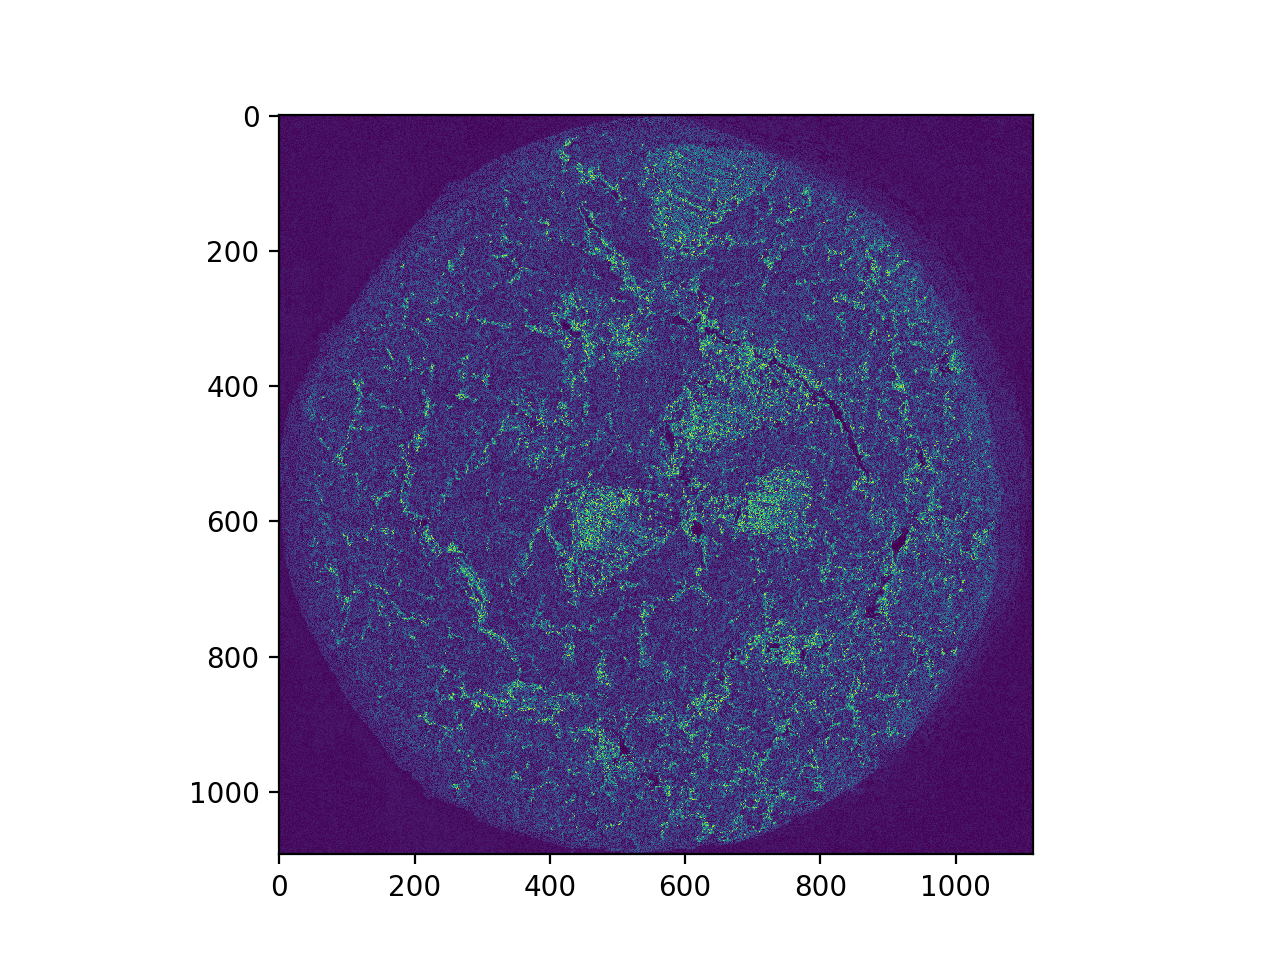

In [103]:
plt.imshow(temp)

In [107]:
def butterworth_filter(I_shape, filter_params):
    P = I_shape[0]/2
    Q = I_shape[1]/2
    U, V = np.meshgrid(range(I_shape[0]), range(I_shape[1]), sparse=False, indexing='ij')
    Duv = (((U-P)**2+(V-Q)**2)).astype(float)
    H = 1/(1+(Duv/filter_params[0]**2)**filter_params[1])
    return (1 - H)

def __apply_filter(I, H):
    H = np.fft.fftshift(H)
#     H =  cv2.dft(np.float32(H), flags=cv2.DFT_COMPLEX_OUTPUT)
    I_filtered = (0.75 + 1.25*H)*I
    return I_filtered

def filter(I, filter_params):
    
    I_log = np.log1p(np.array(I, dtype="float"))
    I_fft = np.fft.fft2(I_log)
    H = butterworth_filter(I_shape = I_fft.shape, filter_params = filter_params)
    I_fft_filt = __apply_filter(I = I_fft, H = H)
    I_filt = np.fft.ifft2(I_fft_filt)
    I = np.exp(np.real(I_filt))-1
    return np.uint8(I)

In [108]:
gray = cv2.bilateralFilter(gray,25,100, 100)
img_filtered = filter(I=gray, filter_params=[75,50])
th2 = cv2.adaptiveThreshold(img_filtered,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,99,2)

<IPython.core.display.Javascript object>


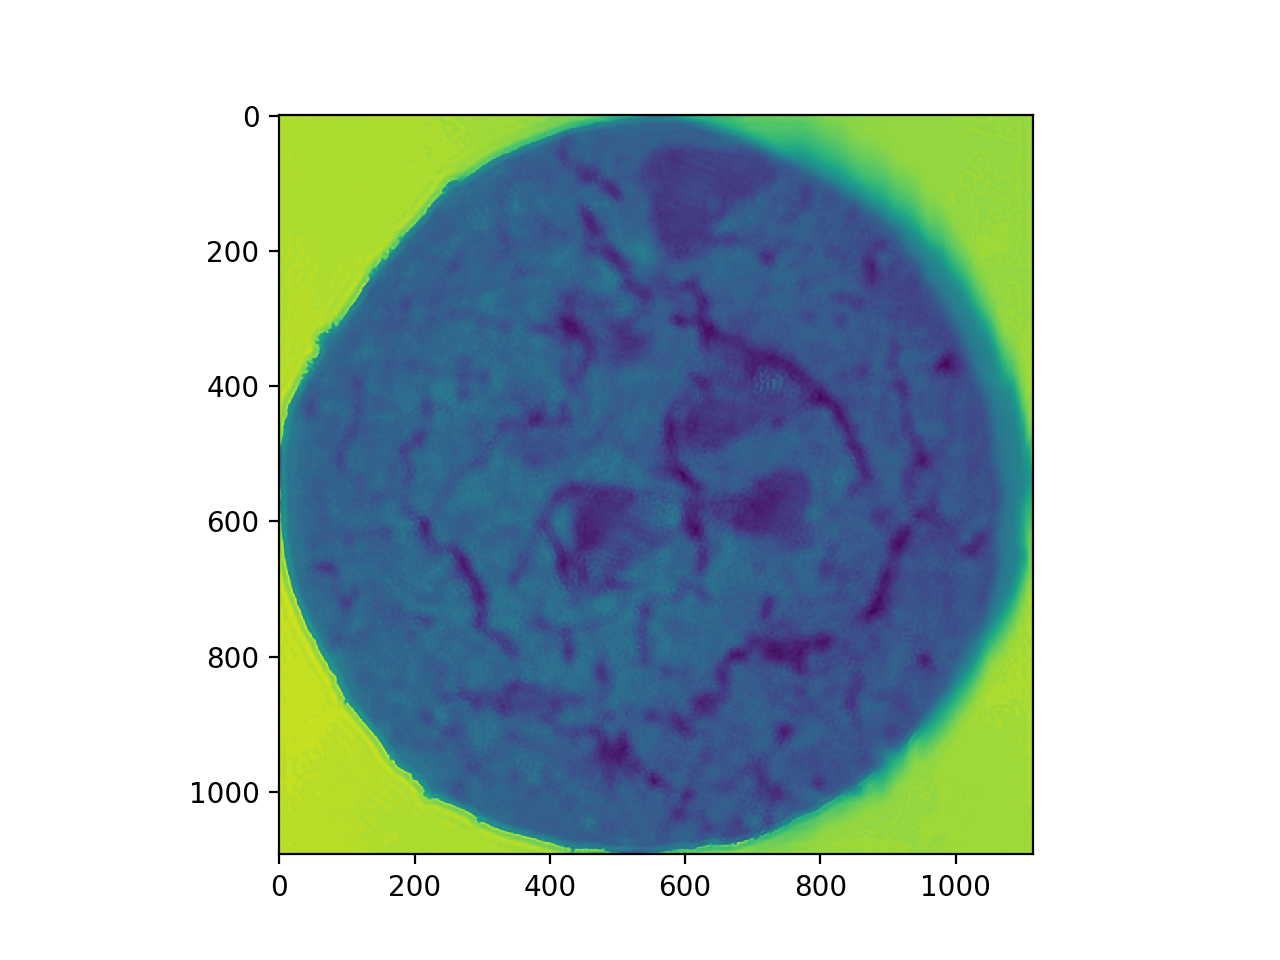

In [112]:
plt.imshow(img_filtered)

<IPython.core.display.Javascript object>


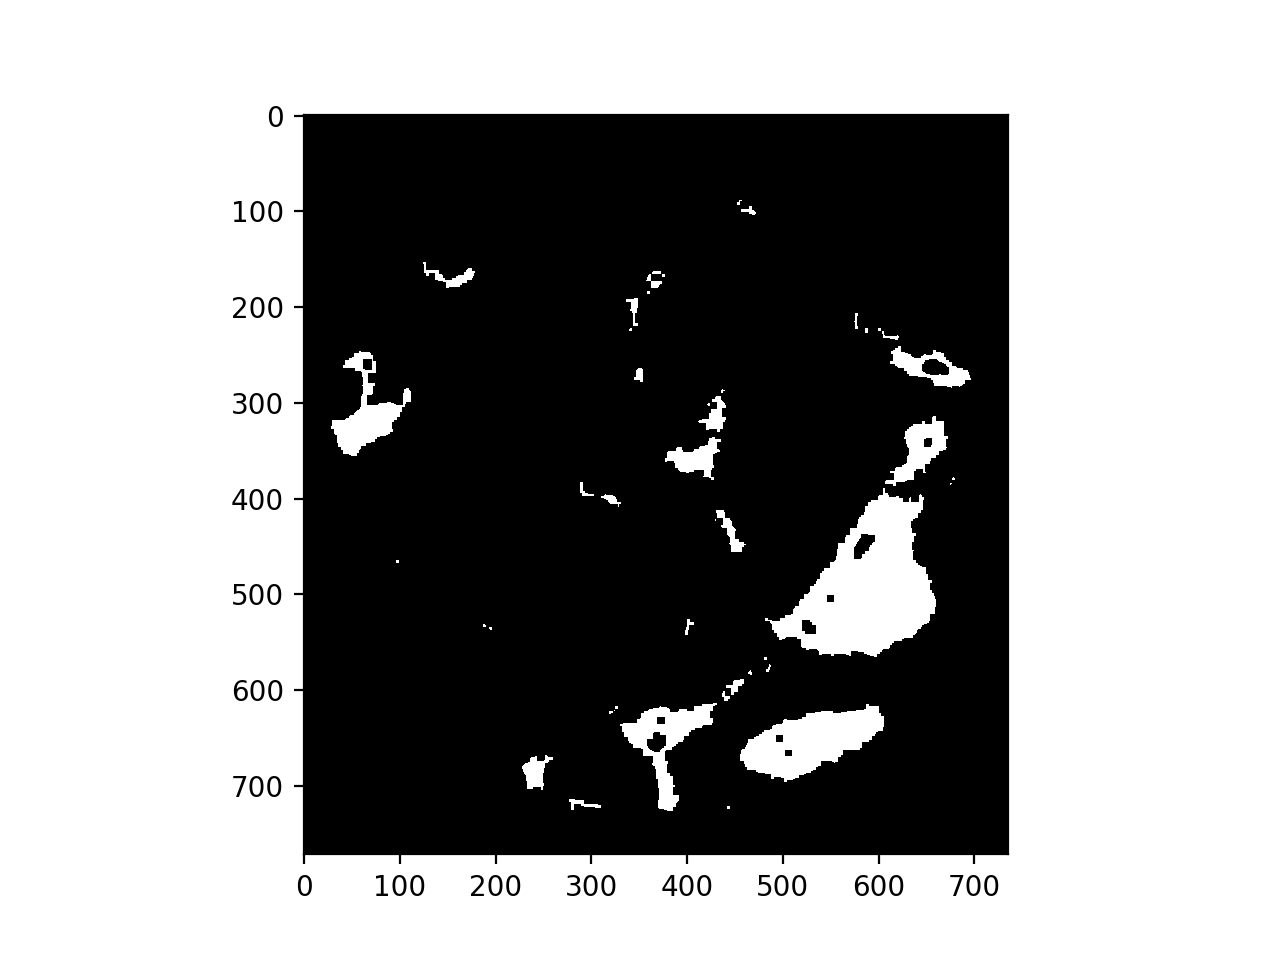

In [182]:
img_c = im_crops[0][:,:,::-1]
xyz = cv2.cvtColor(img_c, cv2.COLOR_BGR2XYZ)
bil = cv2.bilateralFilter(xyz,30,150, 150)
x,y, z = cv2.split(bil)

temp = x*y/z
temp = (temp/np.nanmax(temp)) * 255.
temp = np.uint8(temp)
ret,th1 = cv2.threshold(temp,100,255,cv2.THRESH_BINARY)
laplacian = cv2.Canny(th1,120,200)
kernel = np.ones((7, 7),np.uint8)
closing = cv2.morphologyEx(laplacian, cv2.MORPH_CLOSE, kernel)

_,contour, hierarchy = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)



plt.imshow(closing, cmap = 'gray')

In [188]:
new_contours = []
for cnt in contour:
    if (cv2.contourArea(cnt)/cv2.contourArea(final_contours[0]))* 100 > 0.5:
        new_contours.append(cnt)
print(len(new_contours))

4


<IPython.core.display.Javascript object>


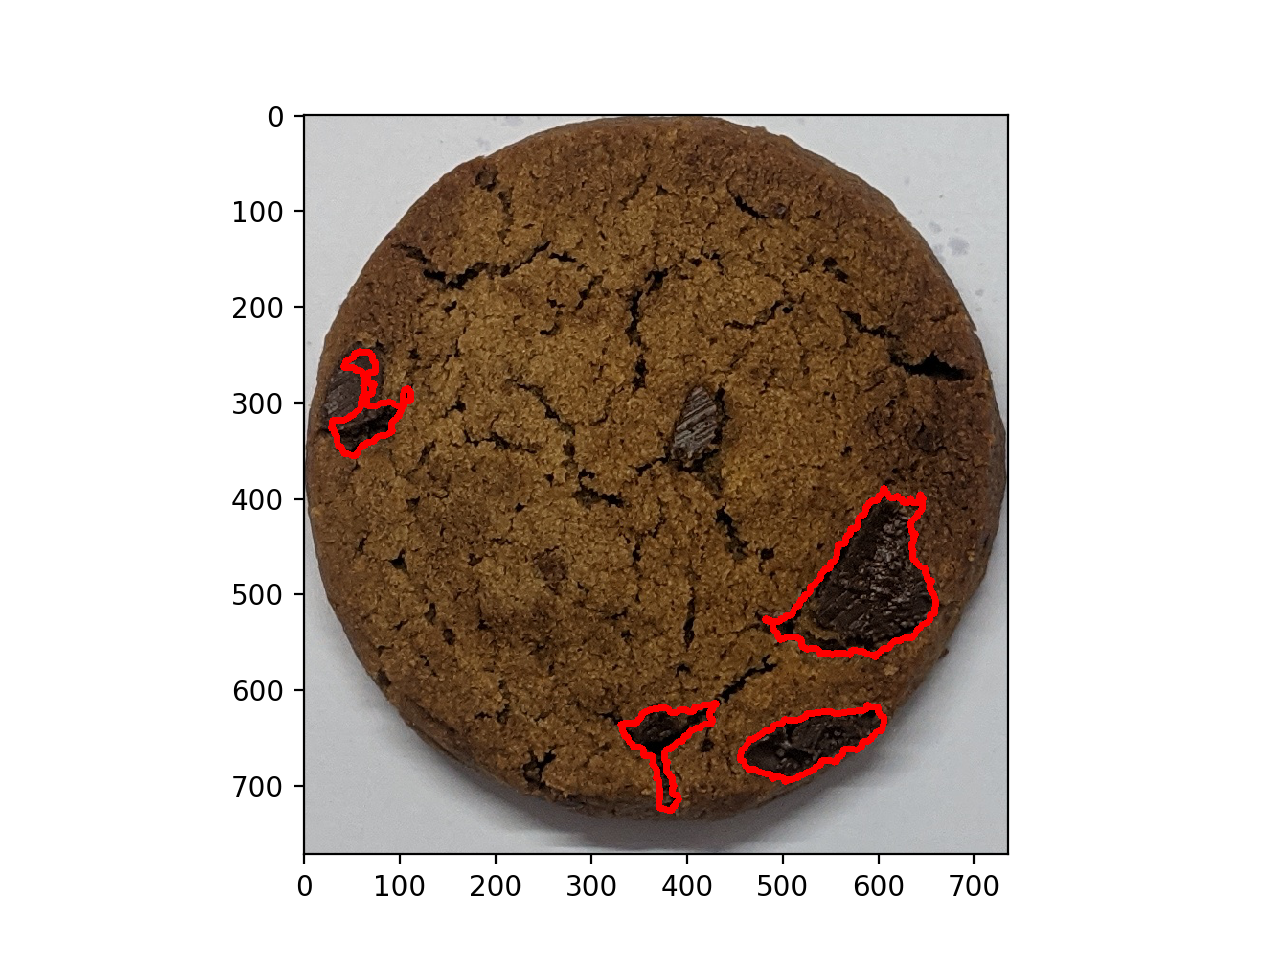

In [194]:
mask = im_crops[0][:,:,::-1].copy()
cv2.drawContours(mask, new_contours, -1, (255,0,0), 5)
plt.imshow(mask)

<IPython.core.display.Javascript object>


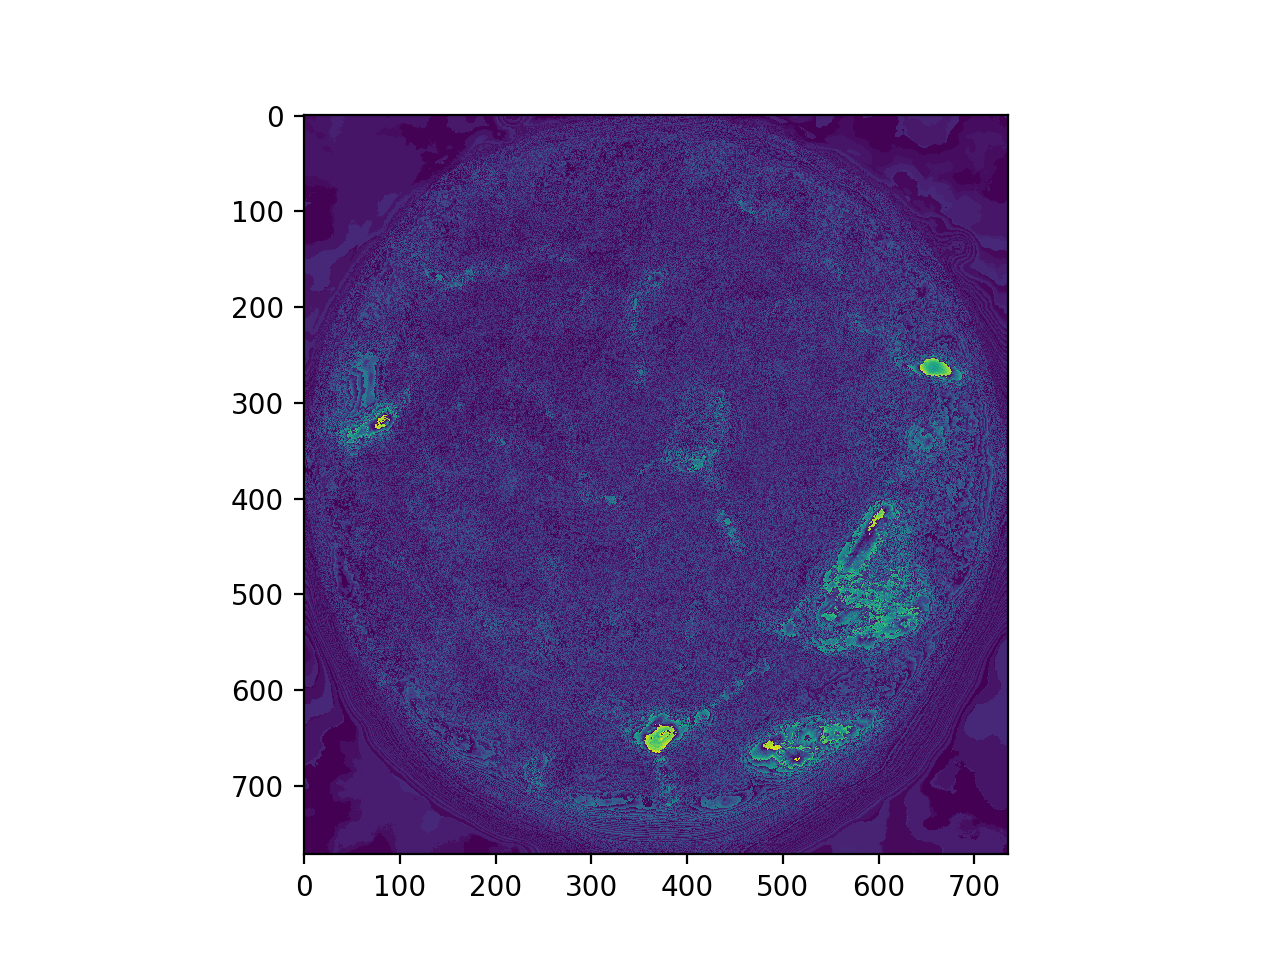

In [190]:
plt.imshow(temp)